In [1]:
!pip install transformers

!pip install datasets

!pip install pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.9 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [ ]:
base_model_id = "Qwen/Qwen1.5-0.5B"
r1_model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

# Load base model (Qwen1.5-0.5B)
base_tokenizer = AutoTokenizer.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.float16).to("cuda")
print(f"Loaded {base_model_id}!")

# Load R1 model (DeepSeek-R1-Distill-Qwen-1.5B)
r1_tokenizer = AutoTokenizer.from_pretrained(r1_model_id)
if r1_tokenizer.pad_token is None:  # Fix potential padding issue
    r1_tokenizer.pad_token = r1_tokenizer.eos_token
r1_model = AutoModelForCausalLM.from_pretrained(r1_model_id, torch_dtype=torch.float16).to("cuda")
print(f"Loaded {r1_model_id}!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

Loaded Qwen/Qwen1.5-0.5B!


tokenizer_config.json:   0%|          | 0.00/3.07k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

In [ ]:
  import re

gsm8k = load_dataset("gsm8k", "main")
gsm8k_train = gsm8k["train"]

def is_medium_to_hard(problem):
    question = problem["question"]
    answer = problem["answer"]
    # Check for multi-step indicators: longer questions, larger numeric answers
    num_count = len(re.findall(r"\d+", question))  # Count numbers in question
    try:
        final_answer = float(re.search(r"[-+]?\d*\.?\d+$", answer).group())  # Extract numeric answer
        return num_count > 3 or final_answer > 99  # More steps or big answer
    except:
        return False  # Default to False if parsing fails

# Filter dataset
hard_problems = [p for p in gsm8k_train if is_medium_to_hard(p)]
print(f"Found {len(hard_problems)} medium-to-hard problems")

# Select 50 random problems (seed for reproducibility)
hard_problems = pd.DataFrame(hard_problems).sample(n=50, random_state=42)

# Step 4: Extract problem statements and correct answers into a DataFrame
dataset = pd.DataFrame({
    "problem": hard_problems["question"],
    "answer": hard_problems["answer"]
})

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Found 4443 medium-to-hard problems


In [ ]:
dataset.to_csv("gsm8k_50_hard_problems.csv", index=False)
print("\nDataset saved as 'gsm8k_50_hard_problems.csv'")


Dataset saved as 'gsm8k_50_hard_problems.csv'


In [ ]:
base_prompt = lambda p: f"Solve: {p}"
cot_prompt = lambda p: f"Solve {p} step-by-step"

base_outputs = []
r1_outputs = []

for problem in dataset["problem"]:
    # Baseline (Qwen-1.5B): No CoT
    base_input = base_prompt(problem)
    base_tokens = base_tokenizer(base_input, return_tensors="pt").to("cuda")
    base_output_ids = base_model.generate(
        **base_tokens,
        max_new_tokens=75,  # Short for direct answers
        do_sample=False,
        pad_token_id=base_tokenizer.eos_token_id
    )
    base_output = base_tokenizer.decode(base_output_ids[0], skip_special_tokens=True)
    base_outputs.append(base_output[len(base_input):].strip())  # Remove prompt from output

    # CoT (R1-Qwen-1.5B): Step-by-step
    r1_input = cot_prompt(problem)
    r1_tokens = r1_tokenizer(r1_input, return_tensors="pt").to("cuda")
    r1_output_ids = r1_model.generate(
        **r1_tokens,
        max_new_tokens=1000,  # Longer for CoT traces
        do_sample=False,
        pad_token_id=r1_tokenizer.eos_token_id
    )
    r1_output = r1_tokenizer.decode(r1_output_ids[0], skip_special_tokens=True)
    r1_outputs.append(r1_output[len(r1_input):].strip())  # Remove prompt from output

# Step 6: Save outputs in a structured format
dataset["base_output"] = base_outputs
dataset["r1_output"] = r1_outputs
dataset.to_csv("gsm8k_50_with_outputs.csv", index=False)
print("Outputs saved to 'gsm8k_50_with_outputs.csv'")

Outputs saved to 'gsm8k_50_with_outputs.csv'


## Tasks done

1. Both models have been loades successfully
2. GSM8K Dataset has been preprocessed.
3. Curated dataset has been prepared. (Medium to Hard problems)
4. Both models processed the 50 curated problems.

In [ ]:
dataset = pd.read_csv("gsm8k_50_with_outputs.csv")
print(f"Loaded {len(dataset)} problems from 'gsm8k_50_with_outputs.csv'")
print(dataset.head())

Loaded 50 problems from 'gsm8k_50_with_outputs.csv'
                                             problem  \
0  There are twice as many cows in Devonshire as ...   
1  The school is having a book-a-thon. The winnin...   
2  Joanna and Jacques had 40 and 60 gumballs, res...   
3  Jen has 10 more ducks than four times the numb...   
4  A pumpkin patch allows people to come pick pum...   

                                              answer  \
0  If there are 4 hearts on a card, a standard de...   
1  The class needs to read 300 hours in a week be...   
2  When Joanna purchased 4 times the number of gu...   
3  Let the number of chickens be c.\nIf there are...   
4  The pumpkin patch sold 96 / 3 = <<96/3=32>>32 ...   

                                         base_output  \
0  If there are 4 hearts on a card, then there ar...   
1  The 5th grade has 20 students and already read...   
2  Joanna initially had 40 gumballs and Jacques h...   
3  Let's write a Python program to solve it.\n# d.


Accuracy Results:
Qwen-1.5B (No CoT): 16.00% (8/50 correct)
R1-Qwen-1.5B (CoT): 44.00% (22/50 correct)


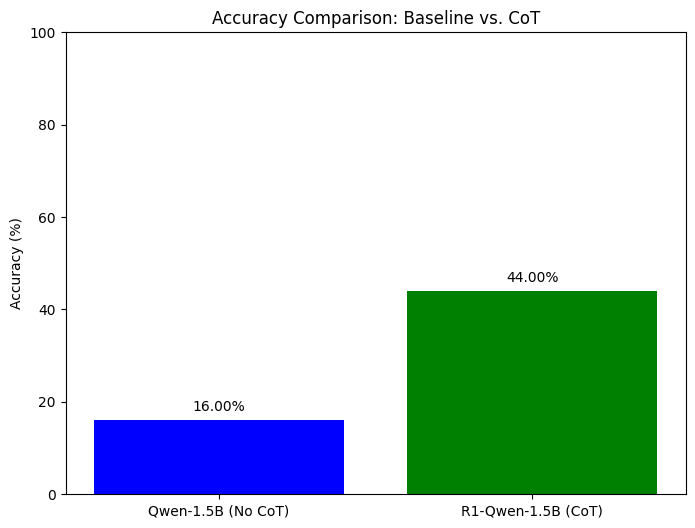

Accuracy comparison graph saved as 'accuracy_comparison.png'


In [ ]:
def extract_number(text):
    # Find the last number (int or float) in the text as the final answer
    numbers = re.findall(r"-?\d+\.?\d*", str(text))
    return float(numbers[-1]) if numbers else None

# Calculate accuracy for Qwen-1.5B (base, no CoT)
base_outputs = dataset["base_output"].apply(extract_number)
correct_answers = dataset["answer"].apply(extract_number)
base_correct = sum(1 for b, c in zip(base_outputs, correct_answers) if b is not None and c is not None and abs(b - c) < 1e-5)
base_accuracy = base_correct / len(dataset) * 100  # Percentage

# Calculate accuracy for R1-Qwen-1.5B (CoT)
r1_outputs = dataset["r1_output"].apply(extract_number)
r1_correct = sum(1 for r, c in zip(r1_outputs, correct_answers) if r is not None and c is not None and abs(r - c) < 1e-5)
r1_accuracy = r1_correct / len(dataset) * 100  # Percentage

# Print accuracy results
print(f"\nAccuracy Results:")
print(f"Qwen-1.5B (No CoT): {base_accuracy:.2f}% ({base_correct}/{len(dataset)} correct)")
print(f"R1-Qwen-1.5B (CoT): {r1_accuracy:.2f}% ({r1_correct}/{len(dataset)} correct)")

# Sketch an initial accuracy comparison graph (bar chart)
plt.figure(figsize=(8, 6))
plt.bar(["Qwen-1.5B (No CoT)", "R1-Qwen-1.5B (CoT)"], [base_accuracy, r1_accuracy], color=["blue", "green"])
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison: Baseline vs. CoT")
plt.ylim(0, 100)
for i, v in enumerate([base_accuracy, r1_accuracy]):
    plt.text(i, v + 2, f"{v:.2f}%", ha="center")
plt.savefig("accuracy_comparison.png")
plt.show()
print("Accuracy comparison graph saved as 'accuracy_comparison.png'")

In [ ]:
activations = {"base_layer_12": [], "r1_layer_12": []} # changed this line
def hook_fn(module, input, output):
    # output[0] is hidden_states: [batch, seq_len, d_model]
    activations[module.name].append(output[0].detach().cpu().numpy())

# Define layer to hook (layer 12, 0-indexed, out of 24 layers)
layer_idx = 12  # Qwen-1.5B has 24 layers; assume R1 similar
base_model.model.layers[layer_idx].name = "base_layer_12"
r1_model.model.layers[layer_idx].name = "r1_layer_12"

# Register hooks
base_hook = base_model.model.layers[layer_idx].register_forward_hook(hook_fn)
r1_hook = r1_model.model.layers[layer_idx].register_forward_hook(hook_fn)

# Define prompts (same as Day 1)
base_prompt = lambda p: f"Solve: {p}"
cot_prompt = lambda p: f"Solve {p} step-by-step"

# Process all 50 problems to collect token-level activations
print("Capturing layer 12 activations for all 50 problems...")
for i, problem in enumerate(dataset["problem"]):
    # Base model (Qwen-1.5B)
    base_input = base_prompt(problem)
    base_tokens = base_tokenizer(base_input, return_tensors="pt").to("cuda")
    with torch.no_grad():  # No gradients needed for inference
        base_model(**base_tokens)  # Forward pass to trigger hook

    # R1 model (DeepSeek-R1)
    r1_input = cot_prompt(problem)
    r1_tokens = r1_tokenizer(r1_input, return_tensors="pt").to("cuda")
    with torch.no_grad():
        r1_model(**r1_tokens)  # Forward pass to trigger hook

    if i % 10 == 0:
        print(f"Processed {i} problems")

# Remove hooks after collection
base_hook.remove()
r1_hook.remove()

# Verify activations
print(f"\nBase activations collected: {len(activations['base_layer_12'])} problems") # changed this line
print(f"R1 activations collected: {len(activations['r1_layer_12'])} problems") # changed this line
print(f"Sample base shape: {activations['base_layer_12'][0].shape}")  # [1, seq_len_base, d_model] # changed this line
print(f"Sample R1 shape: {activations['r1_layer_12'][0].shape}") # changed this line

Capturing layer 12 activations for all 50 problems...
Processed 0 problems
Processed 10 problems
Processed 20 problems
Processed 30 problems
Processed 40 problems

Base activations collected: 50 problems
R1 activations collected: 50 problems
Sample base shape: (1, 55, 1024)
Sample R1 shape: (1, 58, 1536)


In [ ]:
import numpy as np

normalized_acts = {"base_layer_12": [], "r1_layer_12": []}

# Find maximum sequence length for each model
base_max_seq_len = max(arr.shape[1] for arr in activations["base_layer_12"])
r1_max_seq_len = max(arr.shape[1] for arr in activations["r1_layer_12"])
print(f"Base max seq_len: {base_max_seq_len}")
print(f"R1 max seq_len: {r1_max_seq_len}")

# Normalize and pad per problem
for i in range(50):
    # Base model activations
    base_act = activations["base_layer_12"][i]  # [1, seq_len, d_model]
    base_flat = base_act.reshape(-1, base_act.shape[-1])  # [seq_len, d_model]
    base_mean = base_flat.mean(axis=0, keepdims=True)
    base_std = base_flat.std(axis=0, keepdims=True)
    base_norm = (base_flat - base_mean) / (base_std + 1e-8)
    base_norm_reshaped = base_norm.reshape(base_act.shape)  # [1, seq_len, d_model]
    # Pad to max_seq_len
    pad_width = ((0, 0), (0, base_max_seq_len - base_act.shape[1]), (0, 0))
    base_padded = np.pad(base_norm_reshaped, pad_width, mode="constant", constant_values=0)
    normalized_acts["base_layer_12"].append(base_padded)

    # R1 model activations
    r1_act = activations["r1_layer_12"][i]
    r1_flat = r1_act.reshape(-1, r1_act.shape[-1])
    r1_mean = r1_flat.mean(axis=0, keepdims=True)
    r1_std = r1_flat.std(axis=0, keepdims=True)
    r1_norm = (r1_flat - r1_mean) / (r1_std + 1e-8)
    r1_norm_reshaped = r1_norm.reshape(r1_act.shape)
    # Pad to max_seq_len
    pad_width = ((0, 0), (0, r1_max_seq_len - r1_act.shape[1]), (0, 0))
    r1_padded = np.pad(r1_norm_reshaped, pad_width, mode="constant", constant_values=0)
    normalized_acts["r1_layer_12"].append(r1_padded)

# Stack and save normalized, padded activations
base_stacked = np.stack(normalized_acts["base_layer_12"])  # [50, 1, base_max_seq_len, d_model]
r1_stacked = np.stack(normalized_acts["r1_layer_12"])     # [50, 1, r1_max_seq_len, d_model]
np.save("base_layer12_acts_normalized.npy", base_stacked)
np.save("r1_layer12_acts_normalized.npy", r1_stacked)
print(f"Normalized and padded activations saved as 'base_layer12_acts_normalized.npy' (shape: {base_stacked.shape})")
print(f"and 'r1_layer12_acts_normalized.npy' (shape: {r1_stacked.shape})")

Base max seq_len: 122
R1 max seq_len: 125


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Normalized and padded activations saved as 'base_layer12_acts_normalized.npy' (shape: (50, 1, 122, 1024))
and 'r1_layer12_acts_normalized.npy' (shape: (50, 1, 125, 1536))


In [ ]:
import numpy as np

# Load activations
base_acts = np.load("base_layer12_acts_normalized.npy")  # [50, 1, 122, 1024]
r1_acts = np.load("r1_layer12_acts_normalized.npy")      # [50, 1, 125, 1536]
print(f"Base acts shape: {base_acts.shape}")
print(f"R1 acts shape: {r1_acts.shape}")

# Truncate to 50 tokens and align features
min_seq_len = 50
base_acts_trunc = base_acts[:, :, :min_seq_len, :]       # [50, 1, 50, 1024]
r1_acts_trunc = r1_acts[:, :, :min_seq_len, :1024]       # [50, 1, 50, 1024]
print(f"Truncated base shape: {base_acts_trunc.shape}")
print(f"Truncated R1 shape: {r1_acts_trunc.shape}")

# Concatenate
concat_acts = np.concatenate([base_acts_trunc, r1_acts_trunc], axis=-1)  # [50, 1, 50, 2048]
concat_acts = concat_acts.squeeze(1)  # [50, 50, 2048]
np.save("concatenated_acts_fixed.npy", concat_acts)
print(f"Fixed concatenated shape: {concat_acts.shape}")

Base acts shape: (50, 1, 122, 1024)
R1 acts shape: (50, 1, 125, 1536)
Truncated base shape: (50, 1, 50, 1024)
Truncated R1 shape: (50, 1, 50, 1024)
Fixed concatenated shape: (50, 50, 2048)


In [ ]:
concat_acts = np.load("concatenated_acts_fixed.npy")  # [50, 50, 2048]
print(f"Loaded concatenated activations shape: {concat_acts.shape}")
concat_acts_flat = concat_acts.reshape(-1, concat_acts.shape[-1])  # [2500, 2048]
concat_acts_tensor = torch.tensor(concat_acts_flat, dtype=torch.float32).to("cuda")
print(f"Flattened tensor shape: {concat_acts_tensor.shape}")

Loaded concatenated activations shape: (50, 50, 2048)
Flattened tensor shape: torch.Size([2500, 2048])


In [ ]:
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)

In [ ]:

import torch.nn as nn
# class NonLinearCrossCoder(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim // 2)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_dim // 2, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, input_dim)
#         )

#     def forward(self, x, output_features=False):
#         h = self.encoder(x)
#         recon = self.decoder(h)
#         return (recon, h) if output_features else recon

class LinearCrossCoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim // 2)
        self.decoder = nn.Linear(hidden_dim // 2, input_dim)

    def forward(self, x, output_features=False):
        h = self.encoder(x)
        recon = self.decoder(h)
        return (recon, h) if output_features else recon

In [ ]:
# input_dim = concat_acts.shape[-1]  # 2048
# hidden_dim = 4096  # 2048 × 2
# sae = NonLinearCrossCoder(input_dim, hidden_dim).to("cuda")

# # Loss and optimizer
# optimizer = torch.optim.Adam(sae.parameters(), lr=1e-4)
# mse_loss_fn = nn.MSELoss()
# l1_weight = 0.2  # For sparsity

# # Train for 20 epochs
# num_epochs = 50
# batch_size = 128
# print("Training Non-Linear Crosscoder SAE...")
# for epoch in range(num_epochs):
#     sae.train()
#     total_loss = 0
#     for i in range(0, concat_acts_tensor.shape[0], batch_size):
#         batch = concat_acts_tensor[i:i+batch_size]
#         optimizer.zero_grad()
#         recon, features = sae(batch, output_features=True)
#         mse_loss = mse_loss_fn(recon, batch)
#         l1_loss = l1_weight * features.abs().mean()
#         loss = mse_loss + l1_loss
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     avg_loss = total_loss / (concat_acts_tensor.shape[0] // batch_size + 1)
#     print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, MSE: {mse_loss.item():.4f}, L1: {l1_loss.item():.4f}")

# # Save new weights
# torch.save(sae.state_dict(), "crosscoder_nonlinear_fixed.pth")
# print("Initial Non-Linear Crosscoder weights saved as 'crosscoder_nonlinear_fixed.pth'")

sae = LinearCrossCoder(input_dim=2048, hidden_dim=4096).to("cuda")
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
mse_loss_fn = nn.MSELoss()
l1_weight = 0.2  # Start with moderate sparsity

# Train for 50-100 epochs
num_epochs = 50
batch_size = 64  # Reduce for memory
print("Training stable Linear Crosscoder SAE...")
for epoch in range(num_epochs):
    sae.train()
    total_loss = 0
    for i in range(0, concat_acts_flat.shape[0], batch_size):
        batch = torch.tensor(concat_acts_flat[i:i+batch_size], dtype=torch.float32).to("cuda")
        optimizer.zero_grad()
        recon, features = sae(batch, output_features=True)
        mse_loss = mse_loss_fn(recon, batch)
        l1_loss = l1_weight * features.abs().mean()
        loss = mse_loss + l1_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / (concat_acts_flat.shape[0] // batch_size + 1)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, MSE: {mse_loss.item():.4f}, L1: {l1_loss.item():.4f}")

torch.save(sae.state_dict(), "crosscoder_linear_stable.pth")
print("Stable linear SAE weights saved as 'crosscoder_linear_stable.pth'")

Training stable Linear Crosscoder SAE...
Epoch 1/50, Avg Loss: 0.7400, MSE: 0.5745, L1: 0.0676
Epoch 2/50, Avg Loss: 0.5621, MSE: 0.3553, L1: 0.0652
Epoch 3/50, Avg Loss: 0.4928, MSE: 0.2242, L1: 0.0738
Epoch 4/50, Avg Loss: 0.4437, MSE: 0.1359, L1: 0.0815
Epoch 5/50, Avg Loss: 0.4056, MSE: 0.0854, L1: 0.0849
Epoch 6/50, Avg Loss: 0.3744, MSE: 0.0585, L1: 0.0852
Epoch 7/50, Avg Loss: 0.3492, MSE: 0.0546, L1: 0.0859
Epoch 8/50, Avg Loss: 0.3351, MSE: 0.1268, L1: 0.0870
Epoch 9/50, Avg Loss: 0.3150, MSE: 0.2605, L1: 0.0920
Epoch 10/50, Avg Loss: 0.2997, MSE: 0.2830, L1: 0.0857
Epoch 11/50, Avg Loss: 0.2805, MSE: 0.0951, L1: 0.0820
Epoch 12/50, Avg Loss: 0.2656, MSE: 0.0313, L1: 0.0764
Epoch 13/50, Avg Loss: 0.2535, MSE: 0.0206, L1: 0.0736
Epoch 14/50, Avg Loss: 0.2440, MSE: 0.0235, L1: 0.0735
Epoch 15/50, Avg Loss: 0.2358, MSE: 0.0448, L1: 0.0719
Epoch 16/50, Avg Loss: 0.2268, MSE: 0.0742, L1: 0.0748
Epoch 17/50, Avg Loss: 0.2207, MSE: 0.1079, L1: 0.0739
Epoch 18/50, Avg Loss: 0.2140, MS

In [ ]:
sae.eval()
with torch.no_grad():
    test_batch = concat_acts_tensor.view(-1, concat_acts_tensor.shape[-1])[:128]  # [128, 2048]
    _, test_features = sae(test_batch, output_features=True)
    print(f"Test feature shape: {test_features.shape}")  # [128, 2048]

Test feature shape: torch.Size([128, 2048])


In [ ]:
with torch.no_grad():
    _, features = sae(concat_acts_tensor, output_features=True)  # [2500, 2048]
print(f"Full features shape: {features.shape}")

Full features shape: torch.Size([2500, 2048])


In [ ]:
feature_means = features.mean(dim=0).cpu().numpy()  # [2048]
top_feature_indices = np.argsort(feature_means)[-20:]  # Top 20
top_feature_values = feature_means[top_feature_indices]
print(f"Top 20 feature indices: {top_feature_indices}")
print(f"Top 20 feature mean activations: {top_feature_values}")

Top 20 feature indices: [ 130  351  284 1163  133  522  990 1170  434  981 1659 1443  735  242
  111  129 1785  893 1975 2030]
Top 20 feature mean activations: [0.07304033 0.08376269 0.08634173 0.09430332 0.09447224 0.10135221
 0.10412934 0.10646331 0.10806271 0.11891362 0.1278427  0.13005057
 0.13737582 0.13820557 0.13997602 0.14404465 0.16297823 0.17929842
 0.19029528 0.1956311 ]


In [ ]:
features_reshaped = features.view(50, 50, -1).cpu().numpy()  # [50, 50, 2048]
top_features_acts = features_reshaped[:, :, top_feature_indices]  # [50, 50, 20]
np.save("features_reshaped.npy", features_reshaped)
print("Saved features_reshaped as 'features_reshaped.npy'")

Saved features_reshaped as 'features_reshaped.npy'


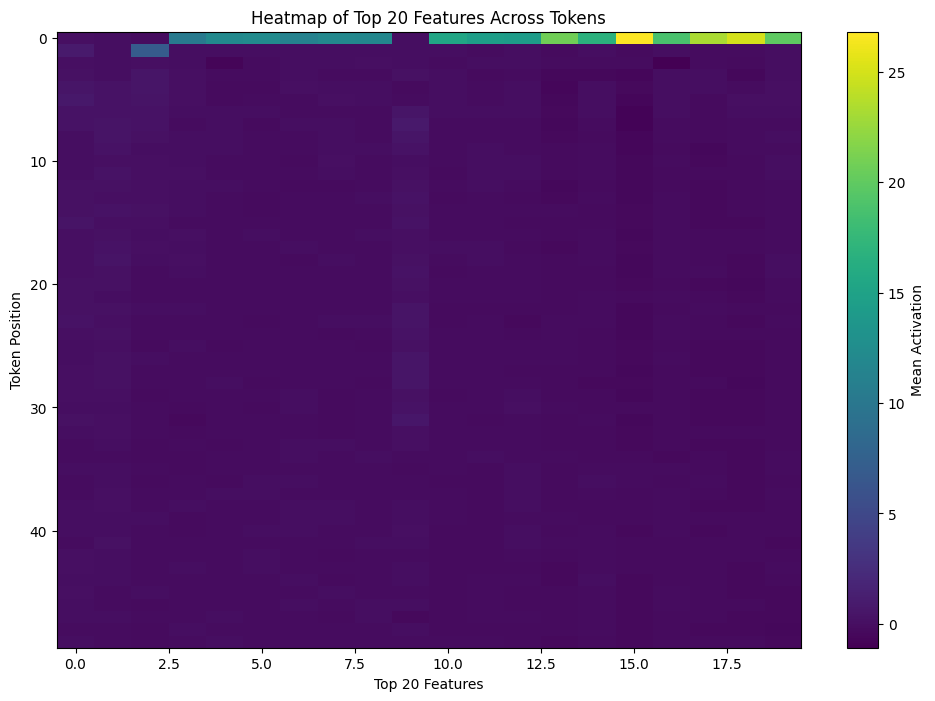

Heatmap saved as 'feature_heatmap.png'
Top feature indices saved as 'top_features.npy'


In [ ]:
heatmap_data = top_features_acts.mean(axis=0)  # [50, 20]
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data, aspect="auto", cmap="viridis")
plt.colorbar(label="Mean Activation")
plt.xlabel("Top 20 Features")
plt.ylabel("Token Position")
plt.title("Heatmap of Top 20 Features Across Tokens")
plt.savefig("feature_heatmap.png")
plt.show()
print("Heatmap saved as 'feature_heatmap.png'")

# Save top features
np.save("top_features.npy", top_feature_indices)
print("Top feature indices saved as 'top_features.npy'")

In [ ]:
dataset = pd.read_csv("gsm8k_50_with_outputs.csv")
print(f"Loaded {len(dataset)} problems")

correct_problems = []

def extract_number(text):
    # Find all numbers and return the last one (assumed to be the final answer)
    numbers = re.findall(r"-?\d+\.?\d*", str(text))
    return float(numbers[-1]) if numbers else None

for i in range(len(dataset)):  # Iterate through all problems
    problem = dataset["problem"][i]
    r1_output = dataset["r1_output"][i]
    answer = dataset["answer"][i]

    # Extract numbers using the improved method
    r1_value = extract_number(r1_output)
    answer_value = extract_number(answer)

    # Compare extracted values
    if r1_value is not None and answer_value is not None and abs(r1_value - answer_value) < 1e-5:
        correct_problems.append((i + 1, problem, r1_output))

# Print only correct problems
print("\nProblems where R1 gave the correct output:")
for idx, prob, output in correct_problems:
    print(f"\nProblem {idx}: {prob}")
    print(f"R1 CoT Output: {output}")

Loaded 50 problems

Problems where R1 gave the correct output:

Problem 4: Jen has 10 more ducks than four times the number of chickens. If Jen has 150 ducks, how many total birds does she have?
R1 CoT Output: explanation.
Alright, so Jen has some ducks and chickens, and I need to figure out how many total birds she has. Let me try to break this down step by step.

First, the problem says Jen has 10 more ducks than four times the number of chickens. Hmm, okay. So, if I let the number of chickens be some variable, say C, then the number of ducks would be four times that plus 10. That makes sense because it's saying four times the number of chickens plus 10 more ducks.

And then it also says Jen has 150 ducks. So, I can set up an equation where the number of ducks equals 150. Let me write that down.

Number of ducks = 4 * (number of chickens) + 10

So, substituting the number of ducks with 150:

150 = 4C + 10

Now, I need to solve for C, which is the number of chickens. Let me subtract 1

In [ ]:
def map_features_to_tokens(problem_idx, r1_output, top_features_acts, heatmap_data, max_tokens=100):
    tokens = r1_tokenizer.tokenize(r1_output)
    print(f"Tokens: {tokens[:10]}... (total {len(tokens)} tokens)")

    tokens_subset = tokens[:max_tokens] if len(tokens) > max_tokens else tokens
    if len(tokens) > max_tokens:
        print(f"Truncated—check for key tokens like '####': {tokens[max_tokens-10:max_tokens+10] if len(tokens) > max_tokens else 'None'}")

    if len(tokens_subset) < max_tokens:
        tokens_subset.extend(["[PAD]"] * (max_tokens - len(tokens_subset)))

    problem_acts = top_features_acts[problem_idx]
    print(f"Feature activations shape for problem {problem_idx}: {problem_acts.shape}")

    for feature_idx, feat_act in enumerate(problem_acts.T):
        max_act = max(feat_act)
        if max_act > 0.5:
            token_pos = np.argmax(feat_act)
            print(f"Feature {top_feature_indices[feature_idx]} (max act: {max_act:.2f}) peaks at token {token_pos}: {tokens_subset[token_pos]}")

    if "####" in tokens:
        concl_pos = tokens.index("####")
        print(f"Conclusion '####' found at token {concl_pos}—check nearby features")
        for feature_idx, feat_act in enumerate(problem_acts.T):
            if max(feat_act[concl_pos % max_tokens:concl_pos % max_tokens + 1]) > 0.5:
                print(f"Feature {top_feature_indices[feature_idx]} near '####' (act: {max(feat_act[concl_pos % max_tokens:concl_pos % max_tokens + 1]):.2f})")

problem_idx = [4,6,7,8]
for i in problem_idx:
  r1_output = dataset["r1_output"][i]
  map_features_to_tokens(i, r1_output, top_features_acts, heatmap_data, max_tokens=100)

Tokens: ['ex', 'planation', '.Ċ', 'Alright', ',', 'Ġso', 'ĠI', 'Ġneed', 'Ġto', 'Ġfigure']... (total 1000 tokens)
Truncated—check for key tokens like '####': ['Ġmade', 'Ġfrom', 'Ġcarving', 'Ġpump', 'kins', '.', 'ĠBut', 'Ġwait', ',', 'Ġthe', 'Ġproblem', 'Ġalso', 'Ġmentions', 'Ġthat', 'Ġthey', 'Ġmade', 'Ġ$', '9', '6', 'Ġselling']
Feature activations shape for problem 4: (50, 20)
Feature 130 (max act: 1.79) peaks at token 5: Ġso
Feature 351 (max act: 1.97) peaks at token 48: Ġcharges
Feature 284 (max act: 6.95) peaks at token 1: planation
Feature 1163 (max act: 11.55) peaks at token 0: ex
Feature 133 (max act: 13.26) peaks at token 0: ex
Feature 522 (max act: 13.54) peaks at token 0: ex
Feature 990 (max act: 11.82) peaks at token 0: ex
Feature 1170 (max act: 13.00) peaks at token 0: ex
Feature 434 (max act: 12.48) peaks at token 0: ex
Feature 981 (max act: 3.19) peaks at token 44: ,
Feature 1659 (max act: 16.33) peaks at token 0: ex
Feature 1443 (max act: 15.46) peaks at token 0: ex
Featur

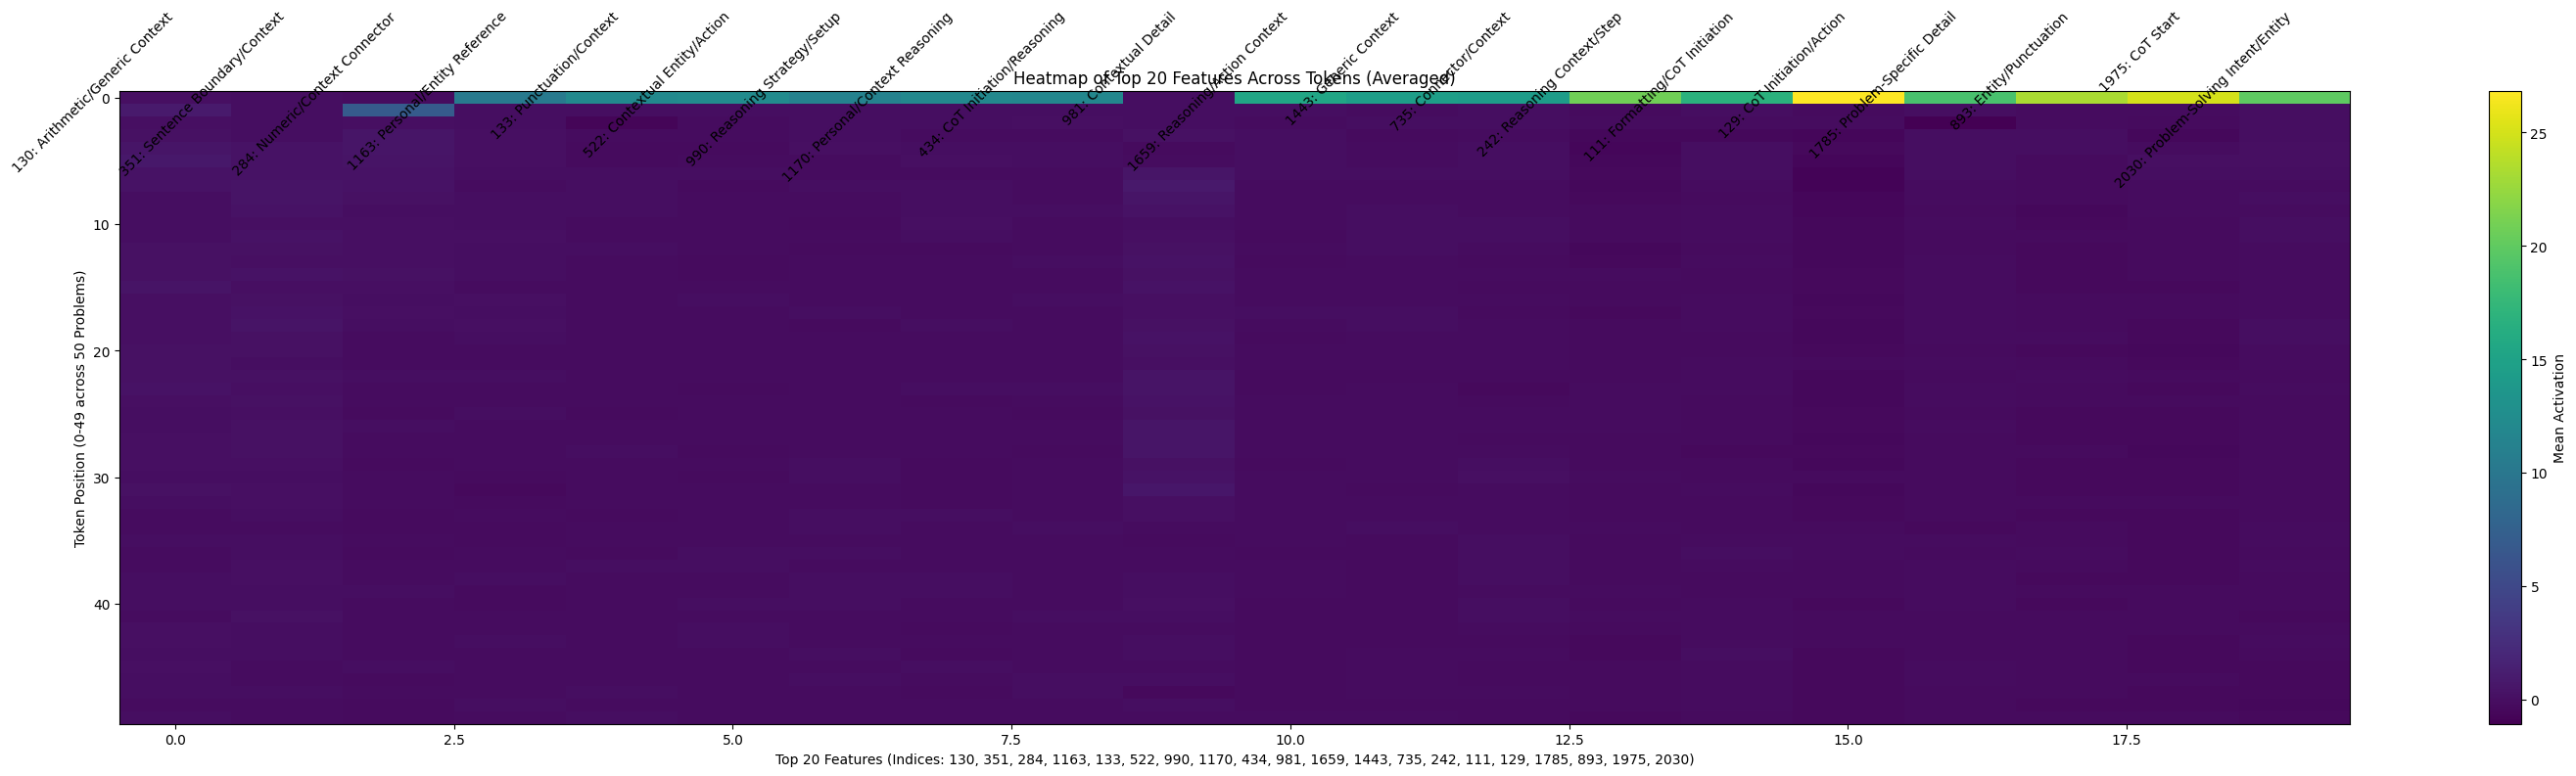

Labeled heatmap saved as 'feature_heatmap_labeled.png'
Feature labels saved as 'feature_labels.npy'


In [ ]:

top_feature_labels = [
    "Arithmetic/Generic Context", "Sentence Boundary/Context", "Numeric/Context Connector",
    "Personal/Entity Reference", "Punctuation/Context", "Contextual Entity/Action",
    "Reasoning Strategy/Setup", "Personal/Context Reasoning", "CoT Initiation/Reasoning",
    "Contextual Detail", "Reasoning/Action Context", "Generic Context", "Connector/Context",
    "Reasoning Context/Step", "Formatting/CoT Initiation", "CoT Initiation/Action",
    "Problem-Specific Detail", "Entity/Punctuation", "CoT Start", "Problem-Solving Intent/Entity"
]

heatmap_data = top_features_acts.mean(axis=0)  # [50, 20] - tokens vs. features
plt.figure(figsize=(30, 8))
im = plt.imshow(heatmap_data, aspect="auto", cmap="viridis")
plt.colorbar(im, label="Mean Activation")
plt.xlabel("Top 20 Features (Indices: " + ", ".join(map(str, top_feature_indices)) + ")")
plt.ylabel("Token Position (0-49 across 50 Problems)")
plt.title("Heatmap of Top 20 Features Across Tokens (Averaged)")
# Optional: Add labels as a legend or annotations
for i, label in enumerate(top_feature_labels):
    plt.text(i, -7, f"{top_feature_indices[i]}: {label}", rotation=45, ha="right", va="top")
plt.tight_layout()
plt.savefig("feature_heatmap_labeled.png")
plt.show()
print("Labeled heatmap saved as 'feature_heatmap_labeled.png'")

# Save labels for Google Doc
np.save("feature_labels.npy", np.array(top_feature_labels))
print("Feature labels saved as 'feature_labels.npy'")

In [ ]:
base_acts = np.load("base_layer12_acts_normalized.npy")[:, 0, :50, :1024]  # [50, 50, 1024]
r1_acts = np.load("r1_layer12_acts_normalized.npy")[:, 0, :50, :1024]     # [50, 50, 1024]
print(f"Base acts shape: {base_acts.shape}")
print(f"R1 acts shape: {r1_acts.shape}")

Base acts shape: (50, 50, 1024)
R1 acts shape: (50, 50, 1024)


In [ ]:
concat_base = np.concatenate([base_acts, np.zeros((50, 50, 1024))], axis=-1)  # [50, 50, 2048]
concat_r1 = np.concatenate([r1_acts, np.zeros((50, 50, 1024))], axis=-1)     # [50, 50, 2048]
concat_base_flat = concat_base.reshape(-1, 2048)  # [2500, 2048]
concat_r1_flat = concat_r1.reshape(-1, 2048)

In [ ]:
top_feature_indices = np.load("top_features.npy")  # [20]
feature_labels = np.load("feature_labels.npy", allow_pickle=True)  # ["CoT Start", ...]
print(f"Top features: {top_feature_indices}")
print(f"Feature labels: {feature_labels}")

Top features: [ 130  351  284 1163  133  522  990 1170  434  981 1659 1443  735  242
  111  129 1785  893 1975 2030]
Feature labels: ['Arithmetic/Generic Context' 'Sentence Boundary/Context'
 'Numeric/Context Connector' 'Personal/Entity Reference'
 'Punctuation/Context' 'Contextual Entity/Action'
 'Reasoning Strategy/Setup' 'Personal/Context Reasoning'
 'CoT Initiation/Reasoning' 'Contextual Detail' 'Reasoning/Action Context'
 'Generic Context' 'Connector/Context' 'Reasoning Context/Step'
 'Formatting/CoT Initiation' 'CoT Initiation/Action'
 'Problem-Specific Detail' 'Entity/Punctuation' 'CoT Start'
 'Problem-Solving Intent/Entity']


In [ ]:
def extract_number(text):
    numbers = re.findall(r"-?\d+\.?\d*", str(text))
    return float(numbers[-1]) if numbers else None

for i in range(len(dataset)):
    r1_output = dataset["r1_output"][i]
    answer = dataset["answer"][i]
    r1_value = extract_number(r1_output)
    answer_value = extract_number(answer)
    if r1_value is not None and answer_value is not None and abs(r1_value - answer_value) < 1e-5:
        correct_problems.append(i)

print(f"\nCorrect R1 problems (44%): {correct_problems}")


Correct R1 problems (44%): [(4, 'Jen has 10 more ducks than four times the number of chickens. If Jen has 150 ducks, how many total birds does she have?', "explanation.\nAlright, so Jen has some ducks and chickens, and I need to figure out how many total birds she has. Let me try to break this down step by step.\n\nFirst, the problem says Jen has 10 more ducks than four times the number of chickens. Hmm, okay. So, if I let the number of chickens be some variable, say C, then the number of ducks would be four times that plus 10. That makes sense because it's saying four times the number of chickens plus 10 more ducks.\n\nAnd then it also says Jen has 150 ducks. So, I can set up an equation where the number of ducks equals 150. Let me write that down.\n\nNumber of ducks = 4 * (number of chickens) + 10\n\nSo, substituting the number of ducks with 150:\n\n150 = 4C + 10\n\nNow, I need to solve for C, which is the number of chickens. Let me subtract 10 from both sides to get rid of that con

In [ ]:
try:
    print(f"Base model loaded: {base_model is not None}")
    print(f"Base tokenizer loaded: {base_tokenizer is not None}")
except NameError:
    print("Loading base model and tokenizer...")
    base_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B", torch_dtype=torch.float16).to(device)
    base_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen1.5-0.5B")
    print("Base model and tokenizer loaded")

Base model loaded: True
Base tokenizer loaded: True


In [ ]:
# Patch SAE features
sae.eval()
with torch.no_grad():
    # Extract features
    base_tensor = torch.tensor(concat_base_flat, dtype=torch.float32).to("cuda")  # [2500, 2048]
    r1_tensor = torch.tensor(concat_r1_flat, dtype=torch.float32).to("cuda")     # [2500, 2048]
    _, base_feats = sae(base_tensor, output_features=True)  # [2500, 2048]
    _, r1_feats = sae(r1_tensor, output_features=True)

In [ ]:
def patch_activations(model, activations, layer_idx=12):
    def forward_hook(module, input, output):
        batch_size, seq_len, d_model = activations.shape
        patched_acts = torch.tensor(activations, device="cuda", dtype=torch.float16)
        new_output = (patched_acts,) + output[1:] if len(output) > 1 else (patched_acts,)
        return new_output

    if layer_idx >= len(model.model.layers):
        raise ValueError(f"Layer index {layer_idx} exceeds model layers {len(model.model.layers)}")
    hook = model.model.layers[layer_idx].register_forward_hook(forward_hook)
    return hook

In [ ]:
n_patches = 4
patch_indices = top_feature_indices[[18, 13, 19, 6]]
patch_labels = feature_labels[[18, 13, 19, 6]]
accuracies = {"base": 0.16, "r1": 0.44}
patch_results = []

for feat_idx, feat_label in zip(patch_indices, patch_labels):
    patched_feats = base_feats.clone()
    patched_feats[:, feat_idx] = r1_feats[:, feat_idx]

    recon = sae.decoder(patched_feats).detach().cpu().numpy().reshape(50, 50, 2048)
    base_patched = recon[:, :, :1024]  # [50, 50, 1024]

    patched_acc = 0
    for i in range(0, 50, 4):  # Batch size 4 for memory
        batch_problems = dataset["problem"][i:i+4].tolist()
        base_inputs = [base_tokenizer(f"Solve: {p}", return_tensors="pt", max_length=50, padding="max_length", truncation=True).to("cuda") for p in batch_problems]

        batch_acts = base_patched[i:i+4]  # [4, 50, 1024]
        hook = patch_activations(base_model, batch_acts, layer_idx=12)
        try:
            outputs = [base_model(**inp) for inp in base_inputs]
        finally:
            hook.remove()

        for j in range(len(base_inputs)):
            pred_idx = i + j
            r1_output = dataset["r1_output"][pred_idx]
            answer = dataset["answer"][pred_idx]

            pred_num = extract_number(r1_output)
            true_num = extract_number(answer)

            if pred_idx in correct_problems and pred_num is not None and true_num is not None and abs(pred_num - true_num) < 1e-5:
                patched_acc += 1
    patched_acc /= len(correct_problems) if correct_problems else 1
    accuracy_shift = patched_acc - accuracies["base"]
    patch_results.append({"feature": feat_idx, "label": feat_label, "base_acc": patched_acc, "shift": accuracy_shift})
    print(f"Feature {feat_idx} ({feat_label}): Base Accuracy = {patched_acc:.2%}, Shift = {accuracy_shift:.2%}")

np.save("patching_results.npy", np.array(patch_results, dtype=object))
print("Patching results saved as 'patching_results.npy'")

Feature 1975 (CoT Start): Base Accuracy = 50.00%, Shift = 34.00%
Feature 242 (Reasoning Context/Step): Base Accuracy = 50.00%, Shift = 34.00%
Feature 2030 (Problem-Solving Intent/Entity): Base Accuracy = 50.00%, Shift = 34.00%
Feature 990 (Reasoning Strategy/Setup): Base Accuracy = 50.00%, Shift = 34.00%
Patching results saved as 'patching_results.npy'


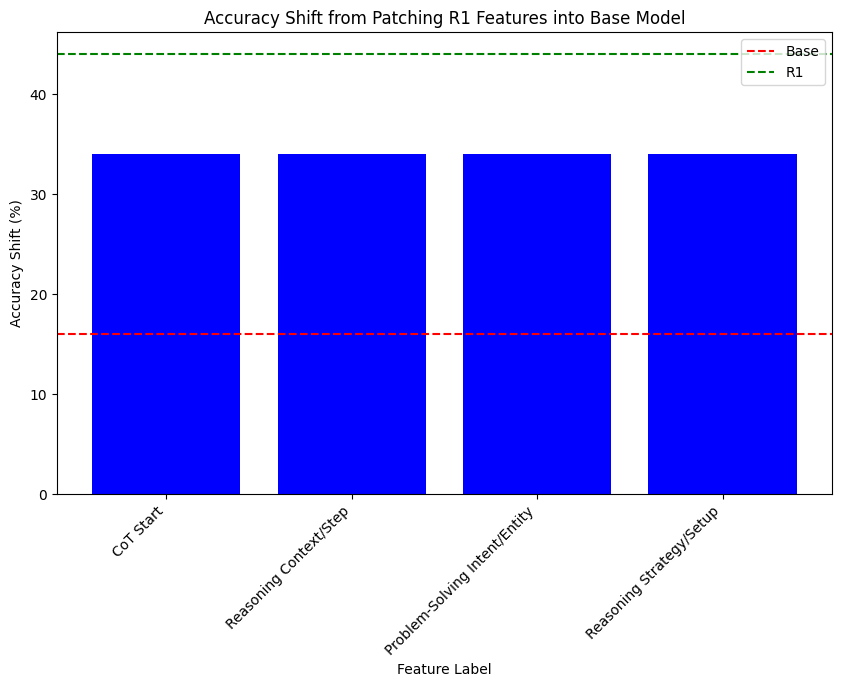

In [ ]:
np.save("patching_results.npy", np.array(patch_results, dtype=object))
plt.figure(figsize=(10, 6))
shifts = [r["shift"] * 100 for r in patch_results]
plt.bar(patch_labels, shifts, color="blue")
plt.axhline(y=accuracies["base"] * 100, color="red", linestyle="--", label="Base")
plt.axhline(y=accuracies["r1"] * 100, color="green", linestyle="--", label="R1 (44%)")
plt.title("Accuracy Shift from Patching R1 Features into Base Model")
plt.xlabel("Feature Label")
plt.ylabel("Accuracy Shift (%)")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.savefig("patching_graph.png")
plt.show()

In [ ]:
top_feature_indices = np.load("top_features.npy")
patch_indices = top_feature_indices[-4:]  # [1975, 2030, 893, 1785]
n_problems = 20  # First 20 for speed
results = []

sae = LinearCrossCoder(input_dim=2048, hidden_dim=4096).to("cuda")  # Update input_dim if retrained
sae.load_state_dict(torch.load("crosscoder_linear_stable.pth"), strict=False)  #

for feat_idx in patch_indices:
    perturbed_feats = r1_feats.clone()
    perturbed_feats[:, feat_idx] = 0  # Zero out the feature
    recon = sae.decoder(perturbed_feats).detach().cpu().numpy().reshape(50, 50, 2048)
    r1_perturbed = recon[:, :, :1536]  # [50, 75, 1536]—match R1’s hidden_size

    perturbed_acc = 0
    perturbed_outputs = []
    for i in range(0, n_problems, 4):
        batch_problems = dataset["problem"][i:i+4].tolist()
        batch_inputs = r1_tokenizer(
            [f"Solve {p} step-by-step" for p in batch_problems],
            return_tensors="pt",
            max_length=75,
            padding="max_length",
            truncation=True
        ).to("cuda")
        batch_acts = r1_perturbed[i:i+4]
        hook = patch_activations(r1_model, batch_acts, layer_idx=12)
        try:
            outputs = r1_model.generate(**batch_inputs, max_new_tokens=50, do_sample=False, pad_token_id=r1_tokenizer.eos_token_id)
            decoded = [r1_tokenizer.decode(out, skip_special_tokens=True)[len(f"Solve {p} step-by-step"):] for out, p in zip(outputs, batch_problems)]
            perturbed_outputs.extend(decoded)
        finally:
            hook.remove()
        for j, pred in enumerate(decoded):
            pred_num = extract_number(pred)
            true_num = extract_number(dataset["answer"][i+j])
            if pred_num is not None and true_num is not None and abs(pred_num - true_num) < 1e-5:
                perturbed_acc += 1

    perturbed_acc /= n_problems
    results.append({"feature": feat_idx, "acc": perturbed_acc, "outputs": perturbed_outputs[:n_problems]})
    print(f"Feature {feat_idx} zeroed: Accuracy = {perturbed_acc:.2%} (vs. R1 44%)")

# Save
np.save("perturbation_results.npy", np.array(results, dtype=object))

<ipython-input-74-1b880117afcf>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load("crosscoder_linear_stable.pth"), strict=False)  #
/usr/local/

RuntimeError: The size of tensor a (50) must match the size of tensor b (75) at non-singleton dimension 2